# Object Detection
- 이미지 내에서 물체의 위치와 그 종류를 찾아내는 것으로 이미지 기반의 문제를 풀기 위해서 다양한 곳에서 필수적으로 사용되는 중요한 기법임.
- 물체의 클래스를 분류(classification)할 뿐만 아니라 위치 측정 (localization)까지 함께 수행하는 작업임.
- Localization은 이미지 내에 하나의 물체(Object)가 있을 때 그 물체의 위치를 특정하는 것이고 Detection은 다수의 물체(Object)가 존재할 때 각 Object의 존재 여부를 파악하고 위치를 특정하며 클래스 분류(Classification)까지 수행하는 것.
-  이미지 내에서 물체의 위치를 표현하는 방법에는 바운딩 박스와 object mask가 있음.

## 바운딩박스
- 이미지 내에서 물체의 위치를 사각형으로 감싼 형태의 도형으로 정의하고 이를 꼭짓점의 좌표로 표현하는 방식임.
- 2개의 점을 표현하는 방식은 두 가지가 있음
  - 첫 번째로 전체 이미지의 좌측 상단을 원점으로 정의하고 바운딩 박스의 좌상단 좌표와 우하단 좌표 두 가지 좌표로 표현하는 방식.
  - 이미지 내의 절대 좌표로 정의하지 않고 바운딩 박스의 폭과 높이로 정의하는 방식. 이 경우 좌측 상단의 점에 대한 상대적인 위치로 물체의 위치를 정의할 수 있음.

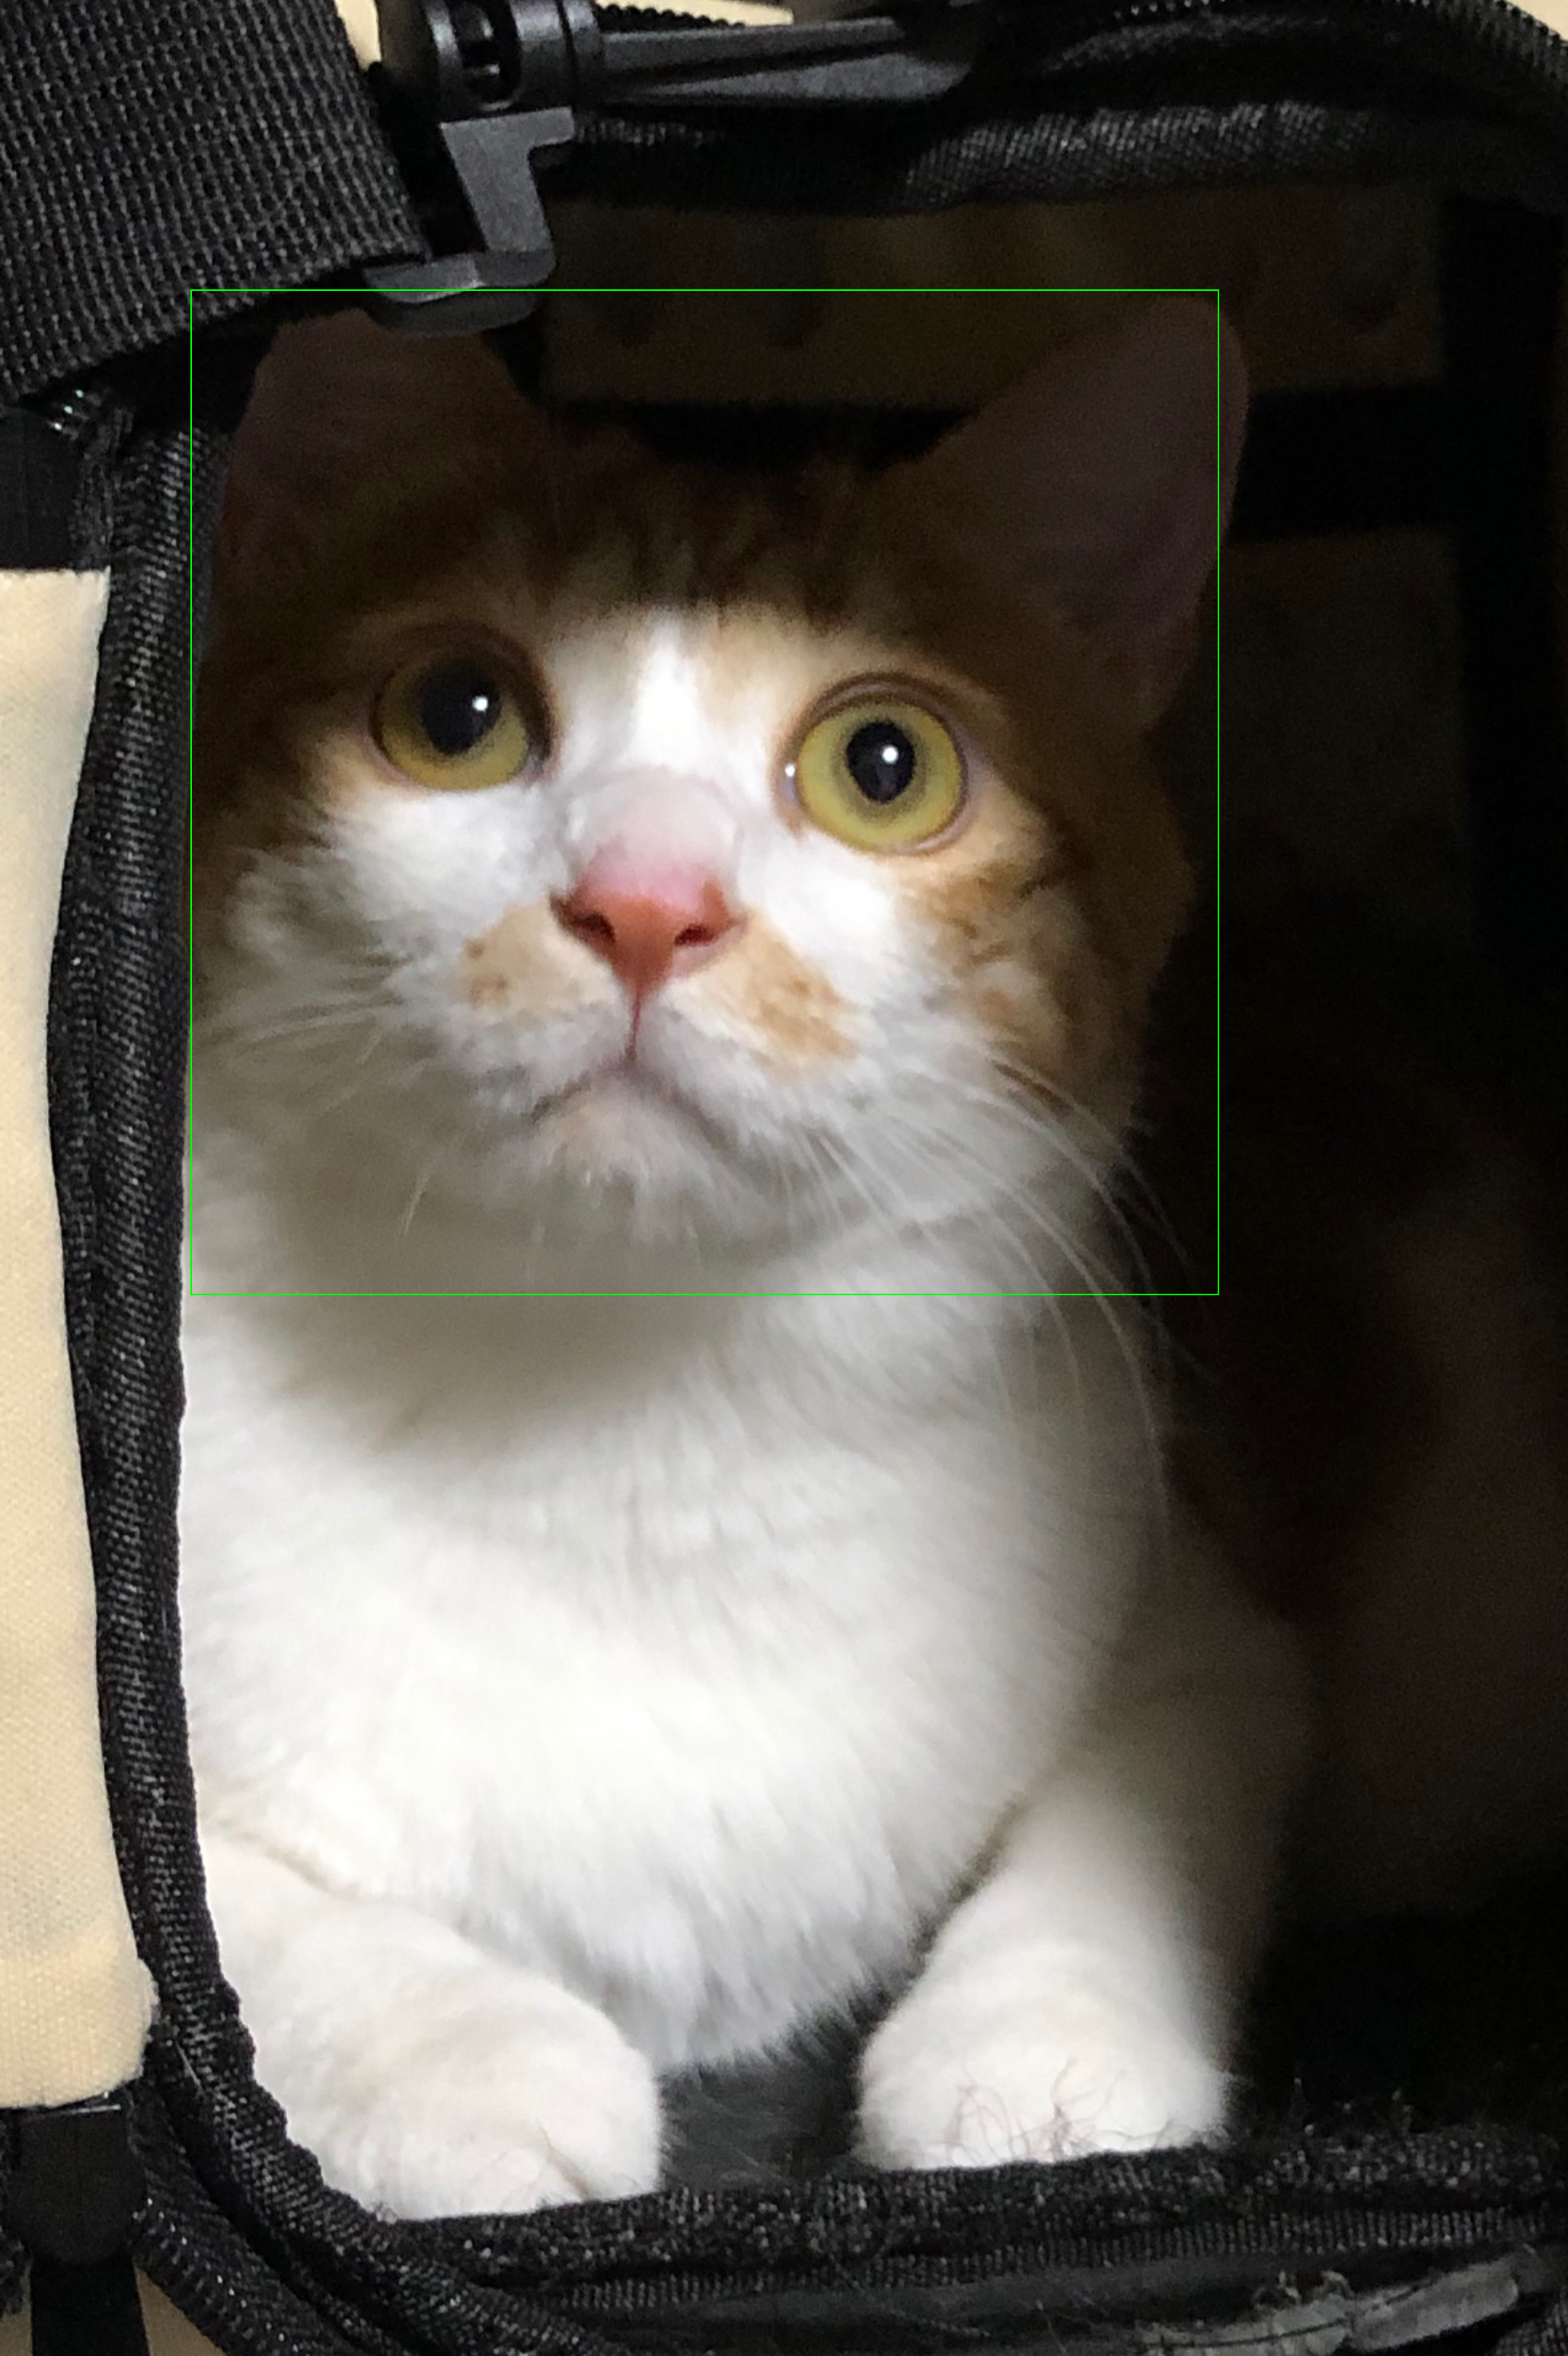

In [10]:
from PIL import Image, ImageDraw
import os

img_path=os.getenv('HOME')+'/aiffel/object_detection/images/image2.jpg'
img = Image.open(img_path)

draw = ImageDraw.Draw(img)
draw.rectangle((250, 380, 1600, 1700), outline=(0,255,0), width=2)

img

## IoU(Intersection over Union)
- 교차하는 영역을 합친 영역으로 나눈 값으로 면적의 절대적인 값에 영향을 받지 않도록 두 개 박스의 차이를 상대적으로 평가하기 위한 방법 중 하나임.|

# Localization
- localization을 위해 박스의 위치를 표현할 output 노드 4개를 convolution layer로 구성된 백본 네트워크 다음에 추가해야 함.

![image](https://github.com/YOOHYOJEONG/AIFFEL_LMS_practice/blob/master/goingdeeper/images/gd_07_image.JPG?raw=true)

- pc는 물체가 있을 확률이고 물체가 있을 때 c1, c2, c 3는 각각 클래스 1, 2, 3에 속할 확률. pc가 0이면 배경인 경우.
- 바운딩 박스를 정의하기 위한 4개의 노드가 추가됨.바운딩 박스 좌측 상단의 점의 위치와 바운딩 박스의 폭과 높이로 박스를 표현함.
- bx, by는 좌측 상단의 점을 표현하는 x축과 y축의 좌표이고 bh와 bw는 바운딩 박스의 높이와 폭이됨. 모두 입력 이미지의 너비 w, 높이 h로 각각 Normalize된 상대적인 좌표와 높이/폭으로 표시됨.

In [11]:
import tensorflow as tf
from tensorflow import keras

output_num = 1+4+3 #object_prob 1, bbox coord 4, class_prob 3

input_tensor = keras.layers.Input(shape=(224, 224, 3), name='image')
base_model = keras.applications.resnet.ResNet50(
    input_tensor=input_tensor,
    include_top=False,    
    weights='imagenet',
    pooling=None,
)

x = base_model.output
preds = keras.layers.Conv2D(output_num, 1, 1)(x)
localize_model=keras.Model(inputs=base_model.input, outputs=preds)

localize_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

- 위 모델에는 위 그림에서 설명한 y가 target label로 제공됨.
- Ground Truth가 되는 bounding box의 좌표(position)은  x1, y1, x2, y2일 때 Bounding box가 x1, y1, x2, y2이고 image의 크기가 w, h 일때 Target label y=[1, x1/w, y1/h, (y2-y1)/h, (x2-x1)/w]가 됨.

# Detection (1) 슬라이딩 윈도우, 컨볼루션

## 슬라이딩 윈도우
-  이미지에서 여러 물체를 찾으려면 전체 이미지를 적당한 크기의 영역으로 나눈 후에, 각각의 영역에 대해 이전 스텝에서 만든 Localization network를 반복 적용해 보는 방식을 생각해 볼 수 있음.
- 이러한 방식을 슬라이딩 윈도우(sliding window) 라고 함.
- Localization network의 입력으로 만들기 위해서 원본 이미지에서 잘라내는 크기를 윈도우 크기로 하여, 동일한 윈도우 사이즈의 영역을 이동시키면서(sliding) 수행해 주는 방식.
- 컨볼루션(Convolution)의 커널이 슬라이딩하는 것과 비슷.
- 처리해야할 window 갯수만큼 시간이 더 걸림.
- 물체의 크기가 다양해지면 단일 크기의 window로 이를 커버할 수 없으므로 더욱 처리속도 문제가 심각해지기 때문에 이렇게 접근하지 않음.

## 컨볼루션(Convolution)
- Sliding window의 단점인 연산량과 속도를 개선하기 위한 방법 중 하나는 Sliding window 대신 convolution을 사용하는 것.
- 병렬적으로 동시에 진행되므로 convolution은 속도 면에서 훨씬 효율적임.
- Sliding window를 한 번에 Convolution으로 연산을 할 수 있음.
- 16x16의 input image를 생각할 때 output에서는 4개의 Bounding box를 얻게되는데, 이때 각각의 Bounding box의 좌표는 서로 다른 원점을 기준으로 좌표가 학습됨. Window가 sliding함에 따라서 window 내에서 물체의 위치는 바뀌게 되는 것. 이때 물체를 표기 하기 위한 bounding box의 원점은 window의 좌측 상단이 원점이 됨.

# Detection (2) 앵커 박스, NMS

## 앵커박스
- 서로 다른 형태의 물체와 겹친 경우에 대응할 수 있음.
- 네트워크가 detect해야 할 object의 shape에 대한 가정(assumption)으로서, 네트워크의 입력임. (바운딩박스는 네트워크의 출력임!)
- 차와 사람이 있는 사진일 때
  - 차와 사람 클래스에 대해서 물체를 감지하기 위해서는 한 개의 그리드 셀에 대한 결괏값 벡터가 물체가 있을 확률, 2개의 클래스, 그리고 바운딩 박스 4개로 총 7개의 차원을 가지게 될 것.
  - 따라서 입력값이 16x16 일 때, 이 그림을 2x2로 총 4칸의 그리드로 나누었다고 하면, 결괏값의 형태는 7개의 채널을 가져 2x2x7이 됨.
  - 이때 7개의 차원을 한 벌 더 늘려주어 한 개의 물체의 수를 늘려주어 앵커 박스가 두 개가 된다면 결괏값의 형태는 2x2x14가 됨.
  - 차만 있는 경우 사람을 담당하는 Anchor box1의 pc가 0이 되고 차를 담당하는 Anchor box2는 pc는 1이 되도록 클래스와 바운딩 박스를 할당함.한 그리드 셀에서 앵커 박스에 대한 물체 할당은 위에서 배운 IoU로 할 수 있음. 인식 범위 내에 물체가 있고 두 개의 앵커 박스가 있는 경우 IoU가 더 높은 앵커 박스에 물체를 할당하게됨.

## NMS(Non-Max Suppression)
- 2x2 또는 더 큰 Grid cell에서 물체가 있는지에 대한 결과를 받게 되면 매우 많은 물체를 받게 되는데  Anchor box를 사용하지 않더라도 2x2격자에 모두 걸친 물체가 있는 경우 하나의 물체에 대해 4개의 Bounding box를 얻게 됨.
- 이렇게 겹친 여러 개의 박스를 하나로 줄여줄 수 있는 방법 중 하나가 NMS(non-max suppression)임.
- NMS는 겹친 박스들이 있을 경우 어느 정도 겹치더라도 다른 물체가 있는 경우가 있을 수 있기 때문에 가장 확률이 높은 박스를 기준으로 기준이 되는 IoU 이상인 것들을 없앰.

# 딥러닝 기반의 Object Detection 모델
- Single stage detector와 Two stage detector로 구분할 수 있음.
- Single stage를 통해서 한번에 연산해내는 것이 속도면에서 빠름.

![model image](https://miro.medium.com/max/2000/1*0ogh_9xVCQ2AMbW6ehC9YQ.png)

- Many stage라고 적혀있는 방법에서는 물체가 있을 법한 위치의 후보(proposals) 들을 뽑아내는 단계, 이후 실제로 물체가 있는지를 Classification과 정확한 바운딩 박스를 구하는 Regression을 수행하는 단계가 분리되어 있으며, 대표적으로 Faster-RCNN을 예로 들 수 있음.
- One stage Detector(single)는 객체의 검출과 분류, 그리고 바운딩 박스 regression을 한 번에 하는 방법임.

## Two-Stage Detector

## R-CNN
-  R-CNN은 물체가 있을 법한 후보 영역을 뽑아내는 "Region proposal" 알고리즘과 후보 영역을 분류하는 CNN을 사용함.
- Proposal을 만들어내는 데에는 Selective search라는 비 신경망 알고리즘이 사용되며 이후에 후보 영역의 Classification과 바운딩 박스의 regression을 위해 신경망을 사용함.

## Fast R-CNN
- Fast R-CNN에서는 후보 영역의 classification과 바운딩 박스 regression을 위한 특성을 한 번에 추출하여 사용함.
- 기존의 Fast R-CNN을 더 빠르게 만들기 위해서 region proposal 과정에서 RPN(Region Proposal Network)라고 불리는 신경망 네트워크를 사용함.

##  One-Stage Detector

## YOLO (You Only Look Once)
- 이미지를 그리드로 나누고, 슬라이딩 윈도 기법을 컨볼루션 연산으로 대체해 Fully Convolutional Network 연산을 통해 그리드 셀 별로 바운딩 박스를 얻어낸 뒤 바운딩 박스들에 대해 NMS를 한 방식임.   


[참고링크1](https://blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=sogangori&logNo=220993971883)

## SSD (Single-Shot Multibox Detector)
- 다양한 크기의 특성 맵으로부터 classification과 바운딩 박스 regression을 수행함.
- 다양한 크기의 물체에 대응할 수 있는 detection 네트워크를 만들 수 있음.

# Anchor

## Matching
- YOLO와 Faster-RCNN에서 Anchor를 기반으로 Loss를 계산하는 방식에는 두 가지 Intersection over Union(IoU)를 threshold로 사용함.
  - Background IoU threshold
  - Foreground IoU threshold
- 영역에 들어간 Anchor box이라도 교차(intersection)하는 면적이 작기 때문에 IoU가 작아 매칭이 되지 않음. 이런 경우에는 Anchor의 크기가 물체의 박스 크기에 비해 매우 작아짐.
- 때문에 탐지하고자 하는 물체에 따라서 Anchor box의 크기나 aspect ratio를 조정해 주어야 함.
- Anchor를 많이 둘 수록 더 많은 Anchor가 물체를 Detection하도록 동작하므로 더 좋은 Recall을 얻을 수 있음.
- 하지만 더 많은 메모리와 연산을 필요로 하기 때문에 적절한 Anchor의 선정이 필요

## Bounding box Regression
- YOLOv3 기준.
- 각 Anchor box에 대응되는 network는 tx, ty , tw, th의 4가지 output으로 bounding box를 regression 해서 정확한 box를 표현하게 됨.
- Bounding box를 예측하기 위해 예측해야 할 것은 bounding box의 중심점(bx, by)과 width(bw),height(bh)인데 직접 예측하는 것이 아니라 anchor box의 정보와 연관지어 찾는 방법을 사용함.